In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df_app=pd.read_csv('application_record.csv')
df_cred=pd.read_csv('credit_record.csv')
print(df_app.head(), "\n" , df_cred.head())

        ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005 

In [3]:
df_app.rename(columns={'ID': 'CUST_ID', 'CODE_GENDER': 'GENDER','FLAG_OWN_CAR': 'OWN_CAR',
                       'FLAG_OWN_REALTY': 'PROPERTY', 'CNT_CHILDREN': 'NUM_CHILDREN',
                       'AMT_INCOME_TOTAL': 'INCOME', 'NAME_INCOME_TYPE': 'INCOME_TYPE',
                       'NAME_EDUCATION_TYPE': 'EDUCATION', 'NAME_FAMILY_STATUS': 'FAMILY_STATUS',
                       'NAME_HOUSING_TYPE': 'HOUSING_TYPE', 'DAYS_BIRTH': 'AGE', 'DAYS_EMPLOYED': 'YEARS_EMPLOYED',
                       'FLAG_MOBIL': 'MOBILE_STATUS', 'FLAG_WORK_PHONE': 'WORK_PHONE_STATUS',
                       'FLAG_PHONE': 'PHONE_STATUS', 'FLAG_EMAIL': 'EMAIL_STATUS','OCCUPATION_TYPE': 'OCCUPATION'}, inplace=True)

df_app['AGE']=(-df_app['AGE']/365).astype(int)
df_app["YEARS_EMPLOYED"] = df_app["YEARS_EMPLOYED"].apply(lambda x: np.round(float(-x / 365)) if pd.notnull(x) and x < 0 else 0)
#0 indicates unemployed, other numbers indicate years employed 
df_app.head()

,CUST_ID,GENDER,OWN_CAR,PROPERTY,NUM_CHILDREN,INCOME,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,AGE,YEARS_EMPLOYED,MOBILE_STATUS,WORK_PHONE_STATUS,PHONE_STATUS,EMAIL_STATUS,OCCUPATION,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32,12.0,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32,12.0,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,58,3.0,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8.0,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8.0,1,0,1,1,Sales staff,1.0


In [4]:
print(df_app['OCCUPATION'].isnull().sum())
avg_income_by_occupation = df_app.groupby('OCCUPATION')['INCOME'].mean().sort_values(ascending=False)
print(avg_income_by_occupation.round(2))

134203
OCCUPATION
Managers                 282125.94
Realty agents            223510.81
Accountants              215137.27
IT staff                 210958.73
HR staff                 203620.69
Drivers                  202065.24
Private service staff    201600.65
High skill tech staff    195712.01
Core staff               190905.84
Laborers                 179865.81
Sales staff              170912.76
Security staff           169835.11
Secretaries              169456.88
Medicine staff           168102.20
Waiters/barmen staff     158796.62
Cooking staff            155848.43
Low-skill Laborers       150334.31
Cleaning staff           147064.46
Name: INCOME, dtype: float64


In [5]:
# Also have to check if null occupation type aligns with unemployed individuals
# Fill null values in OCCUPATION_TYPE with the occupation that has the closest average income to the person's income
def assign_occupation(row):
    if pd.isna(row['OCCUPATION']):
        # Find the occupation with closest average income to this person's income
        closest_occupation = (avg_income_by_occupation - row['INCOME']).abs().idxmin()
        return closest_occupation
    return row['OCCUPATION']

df_app['OCCUPATION'] = df_app.apply(assign_occupation, axis=1)
print(f"Null values after imputation: {df_app['OCCUPATION'].isnull().sum()}")

Null values after imputation: 0


In [6]:
counts = df_app['CUST_ID'].value_counts()

if counts.max() > 1:
    print(counts[counts > 1], "\n", df_app['CUST_ID'].duplicated().sum())
else:
    print("No duplicates found!")

CUST_ID
7702516    2
7602432    2
7836971    2
7213374    2
7052783    2
7023651    2
7838075    2
7636389    2
7052812    2
7372589    2
7155150    2
7090931    2
7091721    2
7137299    2
7744386    2
7772847    2
7636756    2
7317997    2
7053557    2
7742853    2
7576316    2
7099881    2
7046068    2
7036518    2
7742298    2
7022197    2
7603224    2
7023108    2
7089090    2
7702238    2
7243768    2
7045885    2
7836711    2
7743418    2
7045794    2
7618285    2
7207977    2
7154598    2
7154819    2
7024111    2
7282535    2
7050948    2
7416167    2
7174719    2
7833087    2
7135270    2
7022327    2
Name: count, dtype: int64 
 47


In [13]:
df_app.info()

<class 'pandas.DataFrame'>
Index: 438557 entries, 0 to 424339
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CUST_ID            438557 non-null  int64  
 1   GENDER             438557 non-null  str    
 2   OWN_CAR            438557 non-null  str    
 3   PROPERTY           438557 non-null  str    
 4   NUM_CHILDREN       438557 non-null  int64  
 5   INCOME             438557 non-null  float64
 6   INCOME_TYPE        438557 non-null  str    
 7   EDUCATION          438557 non-null  str    
 8   FAMILY_STATUS      438557 non-null  str    
 9   HOUSING_TYPE       438557 non-null  str    
 10  AGE                438557 non-null  int64  
 11  YEARS_EMPLOYED     438557 non-null  float64
 12  MOBILE_STATUS      438557 non-null  int64  
 13  WORK_PHONE_STATUS  438557 non-null  int64  
 14  PHONE_STATUS       438557 non-null  int64  
 15  EMAIL_STATUS       438557 non-null  int64  
 16  OCCUPATION        

In [7]:
df_app[df_app['CUST_ID']==7089090]#Duplicates in df_app seem to be retired individuals and individuals switching jobs   

,CUST_ID,GENDER,OWN_CAR,PROPERTY,NUM_CHILDREN,INCOME,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,AGE,YEARS_EMPLOYED,MOBILE_STATUS,WORK_PHONE_STATUS,PHONE_STATUS,EMAIL_STATUS,OCCUPATION,CNT_FAM_MEMBERS
425539,7089090,F,N,N,1,180000.0,Working,Secondary / secondary special,Married,House / apartment,38,2.0,1,0,1,0,Laborers,3.0
426198,7089090,F,N,Y,1,189000.0,Commercial associate,Incomplete higher,Married,House / apartment,27,5.0,1,0,0,0,Core staff,3.0


In [8]:
df_app = df_app.sort_values(['CUST_ID', 'AGE'])

#Identify "peaks" where a job ended 
# (i.e., the next recorded experience for that person is lower than the current one)
is_job_end = df_app.groupby('CUST_ID')['YEARS_EMPLOYED'].shift(-1) < df_app['YEARS_EMPLOYED']
df_app['Finished_Job_Exp'] = df_app['YEARS_EMPLOYED'].where(is_job_end, 0)

#Create other features
df_app['INCOME_GROWTH'] = df_app.groupby('CUST_ID')['INCOME'].diff().fillna(0)
# Calculate percentage change (Income Diff / Previous Income)
df_app['INCOME_PCT_CHANGE'] = np.round(df_app.groupby('CUST_ID')['INCOME'].pct_change().fillna(0), 2)
df_app['CAREER_CHANGES'] = df_app.groupby('CUST_ID')['OCCUPATION'].transform('nunique')
df_app['INCOME_PER_CAPITA'] = df_app['INCOME'] / np.where(df_app['CNT_FAM_MEMBERS'] == 0, 1, df_app['CNT_FAM_MEMBERS'])
df_app['INCOME_PER_CAPITA'] = df_app['INCOME_PER_CAPITA'].round(2)

prior_exp = df_app.groupby('CUST_ID')['Finished_Job_Exp'].sum()

#Keep the most recent snapshot and map the prior experience back
df_app_final = df_app.groupby('CUST_ID').last().reset_index()
df_app_final['TOTAL_EXPERIENCE'] = df_app_final['CUST_ID'].map(prior_exp) + df_app_final['YEARS_EMPLOYED']

# Optional: Clean up helper column
df_app_final.drop(columns=['Finished_Job_Exp', 'INCOME_GROWTH'], inplace=True)
df_app_final[df_app_final['CUST_ID']==7089090] #Checking for the columns and duplicates

,CUST_ID,GENDER,OWN_CAR,PROPERTY,NUM_CHILDREN,INCOME,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,...,MOBILE_STATUS,WORK_PHONE_STATUS,PHONE_STATUS,EMAIL_STATUS,OCCUPATION,CNT_FAM_MEMBERS,INCOME_PCT_CHANGE,CAREER_CHANGES,INCOME_PER_CAPITA,TOTAL_EXPERIENCE
426759,7089090,F,N,N,1,180000.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,1,0,Laborers,3.0,-0.05,2,60000.0,7.0


In [9]:
#Calculate numeric growth
growth_numeric = df_app_final.groupby('CUST_ID')['INCOME'].diff()

is_first_record = growth_numeric.isna()
single_career = (df_app_final['CAREER_CHANGES'] == 1)

conditions = [
    # Newbie: First record, low experience, and only 1 career path
    (is_first_record) & (df_app_final['TOTAL_EXPERIENCE'] <= 1) & (single_career), #Threshold as 1 for newbie
    
    # Legacy: First record, high experience, and only 1 career path
    (is_first_record) & (df_app_final['TOTAL_EXPERIENCE'] > 1) & (single_career), #to handle rapid career changes within a short span of time

    # Case: Unstable
    (growth_numeric < 0) | (df_app_final['INCOME_PCT_CHANGE'] < 0),
    
    # Case: Stable
    (growth_numeric >= 0) | (df_app_final['INCOME_PCT_CHANGE'] >= 0)
]

# Labels
choices = ['newbie', 'legacy', 'unstable', 'stable']

# Apply logic (Default to 'transitional' or 'other' if they have >1 career change)
df_app_final['INCOME_STABILITY_CAT'] = np.select(conditions, choices, default='transitional')
df_app_final.drop(columns=['CAREER_CHANGES'], inplace=True)

In [10]:
df_app_final['INCOME_STABILITY_CAT'].value_counts()

INCOME_STABILITY_CAT
legacy      309571
newbie      128895
stable          26
unstable        18
Name: count, dtype: int64

In [11]:
counts_cred = df_cred['ID'].value_counts()

if counts_cred.max() > 1:
    print(counts_cred[counts_cred > 1])
    print(f"Total duplicate IDs in credit record: {len(counts_cred[counts_cred > 1])}")
else:
    print("No duplicates found!")

ID
5001730    61
5002160    61
5002165    61
5002171    61
5002283    61
           ..
5150062     2
5150130     2
5150242     2
5150466     2
5150485     2
Name: count, Length: 45586, dtype: int64
Total duplicate IDs in credit record: 45586


In [12]:
print(df_cred[df_cred['ID'] == 5001730])
#the duplicate values is a time series so we need to do some feature engineering 

          ID  MONTHS_BALANCE STATUS
377  5001730               0      C
378  5001730              -1      C
379  5001730              -2      C
380  5001730              -3      C
381  5001730              -4      C
..       ...             ...    ...
433  5001730             -56      0
434  5001730             -57      0
435  5001730             -58      0
436  5001730             -59      0
437  5001730             -60      0

[61 rows x 3 columns]


In [ ]:
#Define the default status
df_cred['is_default'] = df_cred['STATUS'].isin(['1','2', '3', '4', '5']).astype(int) #90 days or more is usually considered default

# FEATURES: Only use months -1 and older (the past)
df_past = df_cred[df_cred['MONTHS_BALANCE'] < 0]

#Month 0 (the current status we want to predict)
df_now = df_cred[df_cred['MONTHS_BALANCE'] == 0] #this will be our test target

df_cred_final = df_past.groupby('ID').agg(
    ACC_AGE=('MONTHS_BALANCE', lambda x: abs(x.min())),
    TOTAL_MONTHS_HISTORY=('MONTHS_BALANCE', 'count'),
    # This is now SAFE because it doesn't know about Month 0
    HISTORICAL_DEFAULTS=('is_default', 'sum') 
).reset_index()

#Create the 'Defaulted Previously' flag using ONLY the past
df_cred_final['DEFAULTED_PREVIOUSLY'] = (df_cred_final['HISTORICAL_DEFAULTS'] > 0).astype(int)

#Merge with the target (Month 0)
# This says: "Given their history up to month -1, did they default in month 0?"
target = df_now[['ID', 'is_default']].rename(columns={'is_default': 'TARGET_DEFAULT'})
df_cred_final= df_cred_final.merge(target, on='ID', how='inner')

print(df_cred_final.head())

        ID  ACC_AGE  TOTAL_MONTHS_HISTORY  HISTORICAL_DEFAULTS  \
0  5001711        3                     3                    0   
1  5001712       18                    18                    0   
2  5001713       21                    21                    0   
3  5001714       14                    14                    0   
4  5001715       59                    59                    0   

   DEFAULTED_PREVIOUSLY  TARGET_DEFAULT  
0                     0               0  
1                     0               0  
2                     0               0  
3                     0               0  
4                     0               0  


In [14]:
df_cred_final['ID'].duplicated().sum()

np.int64(0)

In [15]:
print("Null values in application record", df_app_final.isnull().sum(),"Null values in credit record", df_cred_final.isnull().sum())
#Occupation Type has the most null values
#We can either drop the column or impute the values

Null values in application record CUST_ID                 0
GENDER                  0
OWN_CAR                 0
PROPERTY                0
NUM_CHILDREN            0
INCOME                  0
INCOME_TYPE             0
EDUCATION               0
FAMILY_STATUS           0
HOUSING_TYPE            0
AGE                     0
YEARS_EMPLOYED          0
MOBILE_STATUS           0
WORK_PHONE_STATUS       0
PHONE_STATUS            0
EMAIL_STATUS            0
OCCUPATION              0
CNT_FAM_MEMBERS         0
INCOME_GROWTH           0
INCOME_PCT_CHANGE       0
CAREER_CHANGES          0
TOTAL_EXPERIENCE        0
INCOME_STABILITY_CAT    0
dtype: int64 Null values in credit record ID                      0
ACC_AGE                 0
TOTAL_MONTHS_HISTORY    0
HISTORICAL_DEFAULTS     0
DEFAULTED_PREVIOUSLY    0
TARGET_DEFAULT          0
dtype: int64


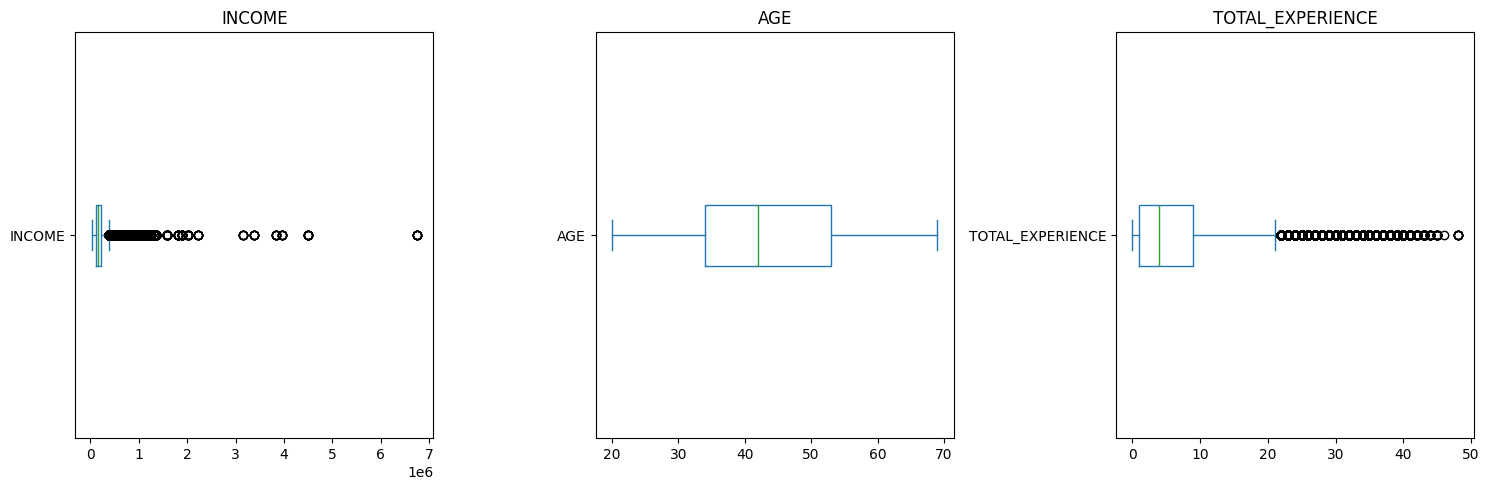

In [16]:
import matplotlib.pyplot as plt
from scipy.stats import mstats

# Create a 1x3 grid (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 

# Use 1D indexing for a 1x3 grid
df_app_final['INCOME'].plot(kind='box', vert=False, ax=axes[0], title='INCOME')
df_app_final['AGE'].plot(kind='box', vert=False, ax=axes[1], title='AGE')
df_app_final['TOTAL_EXPERIENCE'].plot(kind='box', vert=False, ax=axes[2], title='TOTAL_EXPERIENCE')

plt.tight_layout()
plt.show()

# Apply winsorizing
df_app_final['INCOME'] = mstats.winsorize(df_app_final['INCOME'], limits=[0.05, 0.05]).data
df_app_final['TOTAL_EXPERIENCE'] = mstats.winsorize(df_app_final['TOTAL_EXPERIENCE'], limits=[0.05, 0.05]).data

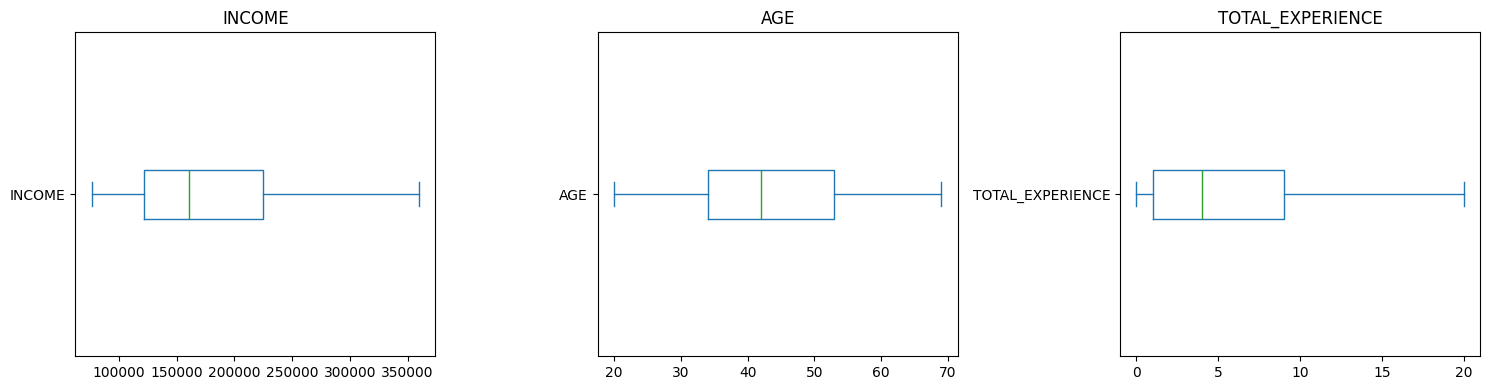

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
df_app_final['INCOME'].plot(kind='box', vert=False, ax=axes[0], title='INCOME')
df_app_final['AGE'].plot(kind='box', vert=False, ax=axes[1], title='AGE')
df_app_final['TOTAL_EXPERIENCE'].plot(kind='box', vert=False, ax=axes[2], title='TOTAL_EXPERIENCE')
plt.tight_layout()
plt.show()

C:\Users\madha\AppData\Local\Temp\ipykernel_12440\2429233632.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  object_cols = df_app_final.select_dtypes(include='object').columns.tolist()


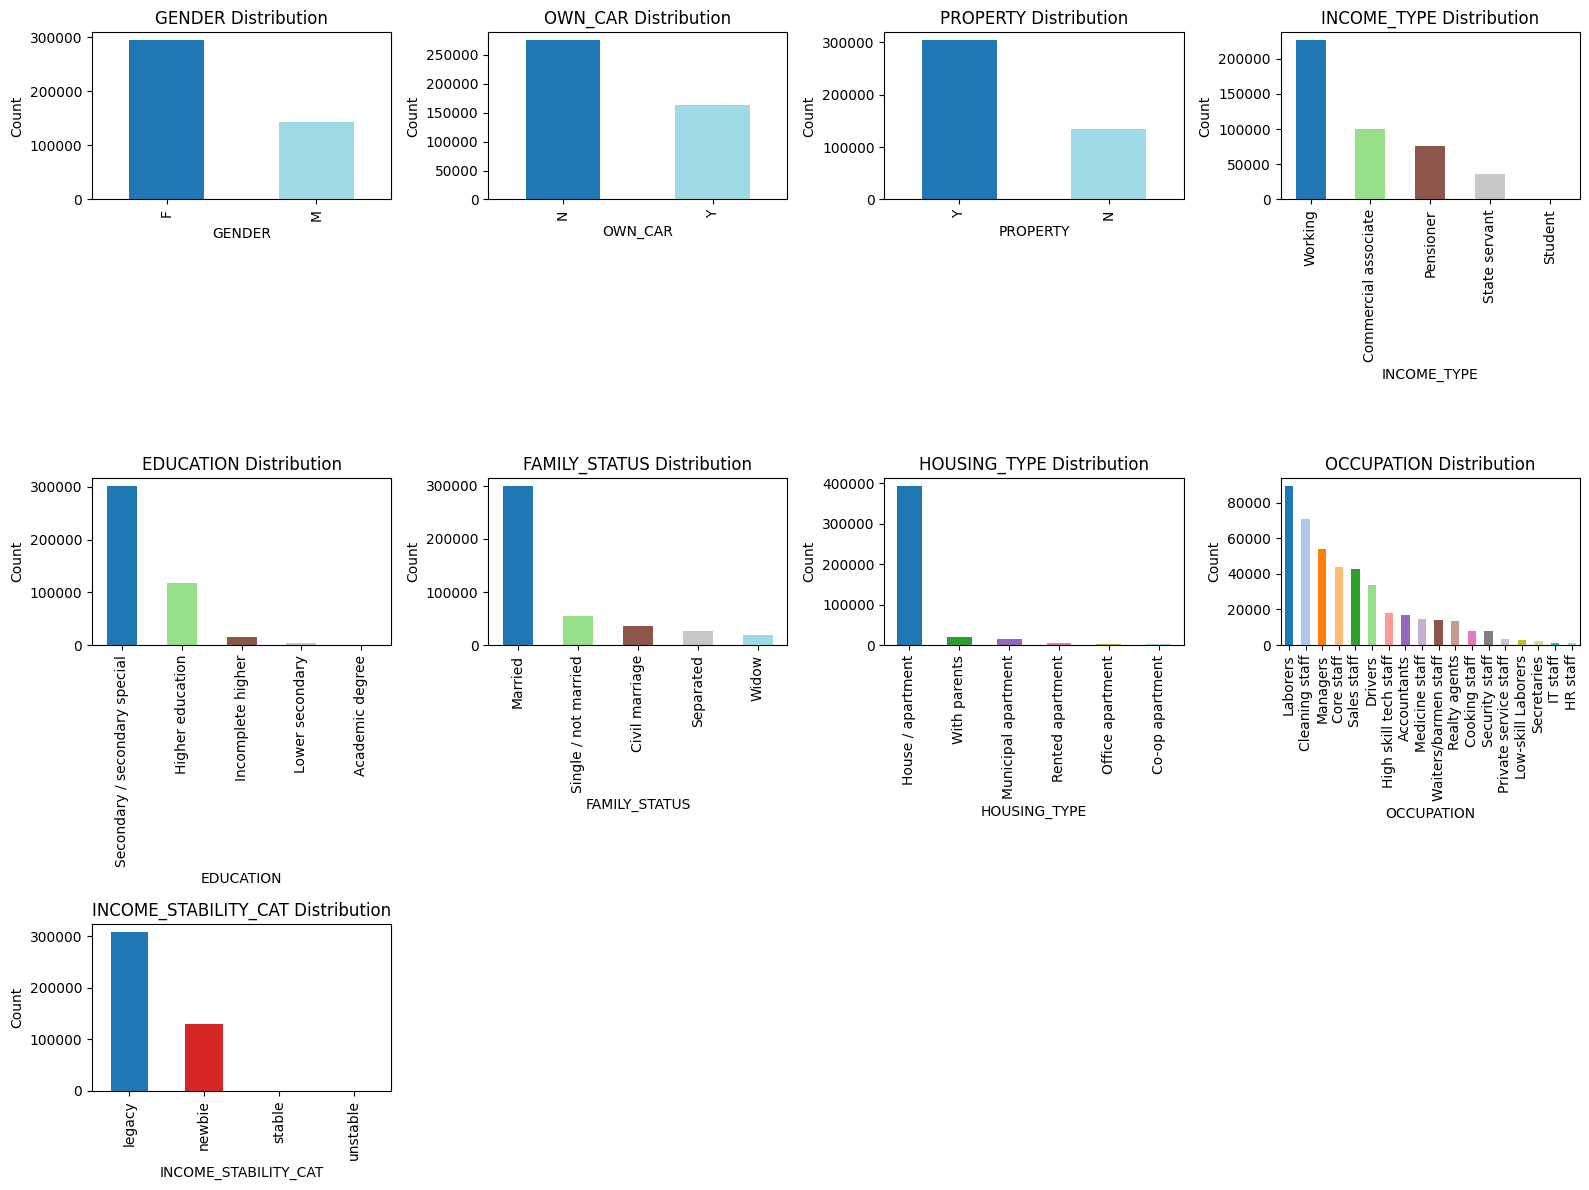

In [18]:
# Get all object (categorical) columns
object_cols = df_app_final.select_dtypes(include='object').columns.tolist()

# Create subplots
nrows = (len(object_cols) + 3) // 4  # 4 columns per row
fig, axes = plt.subplots(nrows, 4, figsize=(16, 4*nrows))
axes = axes.flatten()  # Flatten to 1D array for easier iteration
cmap = plt.get_cmap('tab20')

# Plot each categorical column
for idx, col in enumerate(object_cols):
    colors = [cmap(i) for i in np.linspace(0, 1, len(df_app_final[col].value_counts()))]
    df_app_final[col].value_counts().plot(kind='bar', ax=axes[idx], color=colors)
    axes[idx].set_title(f'{col} Distribution')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')

# Hide unused subplots
for idx in range(len(object_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

In [19]:
df_cred_final.columns

Index(['ID', 'ACC_AGE', 'TOTAL_MONTHS_HISTORY', 'HISTORICAL_DEFAULTS',
       'DEFAULTED_PREVIOUSLY', 'TARGET_DEFAULT'],
      dtype='str')

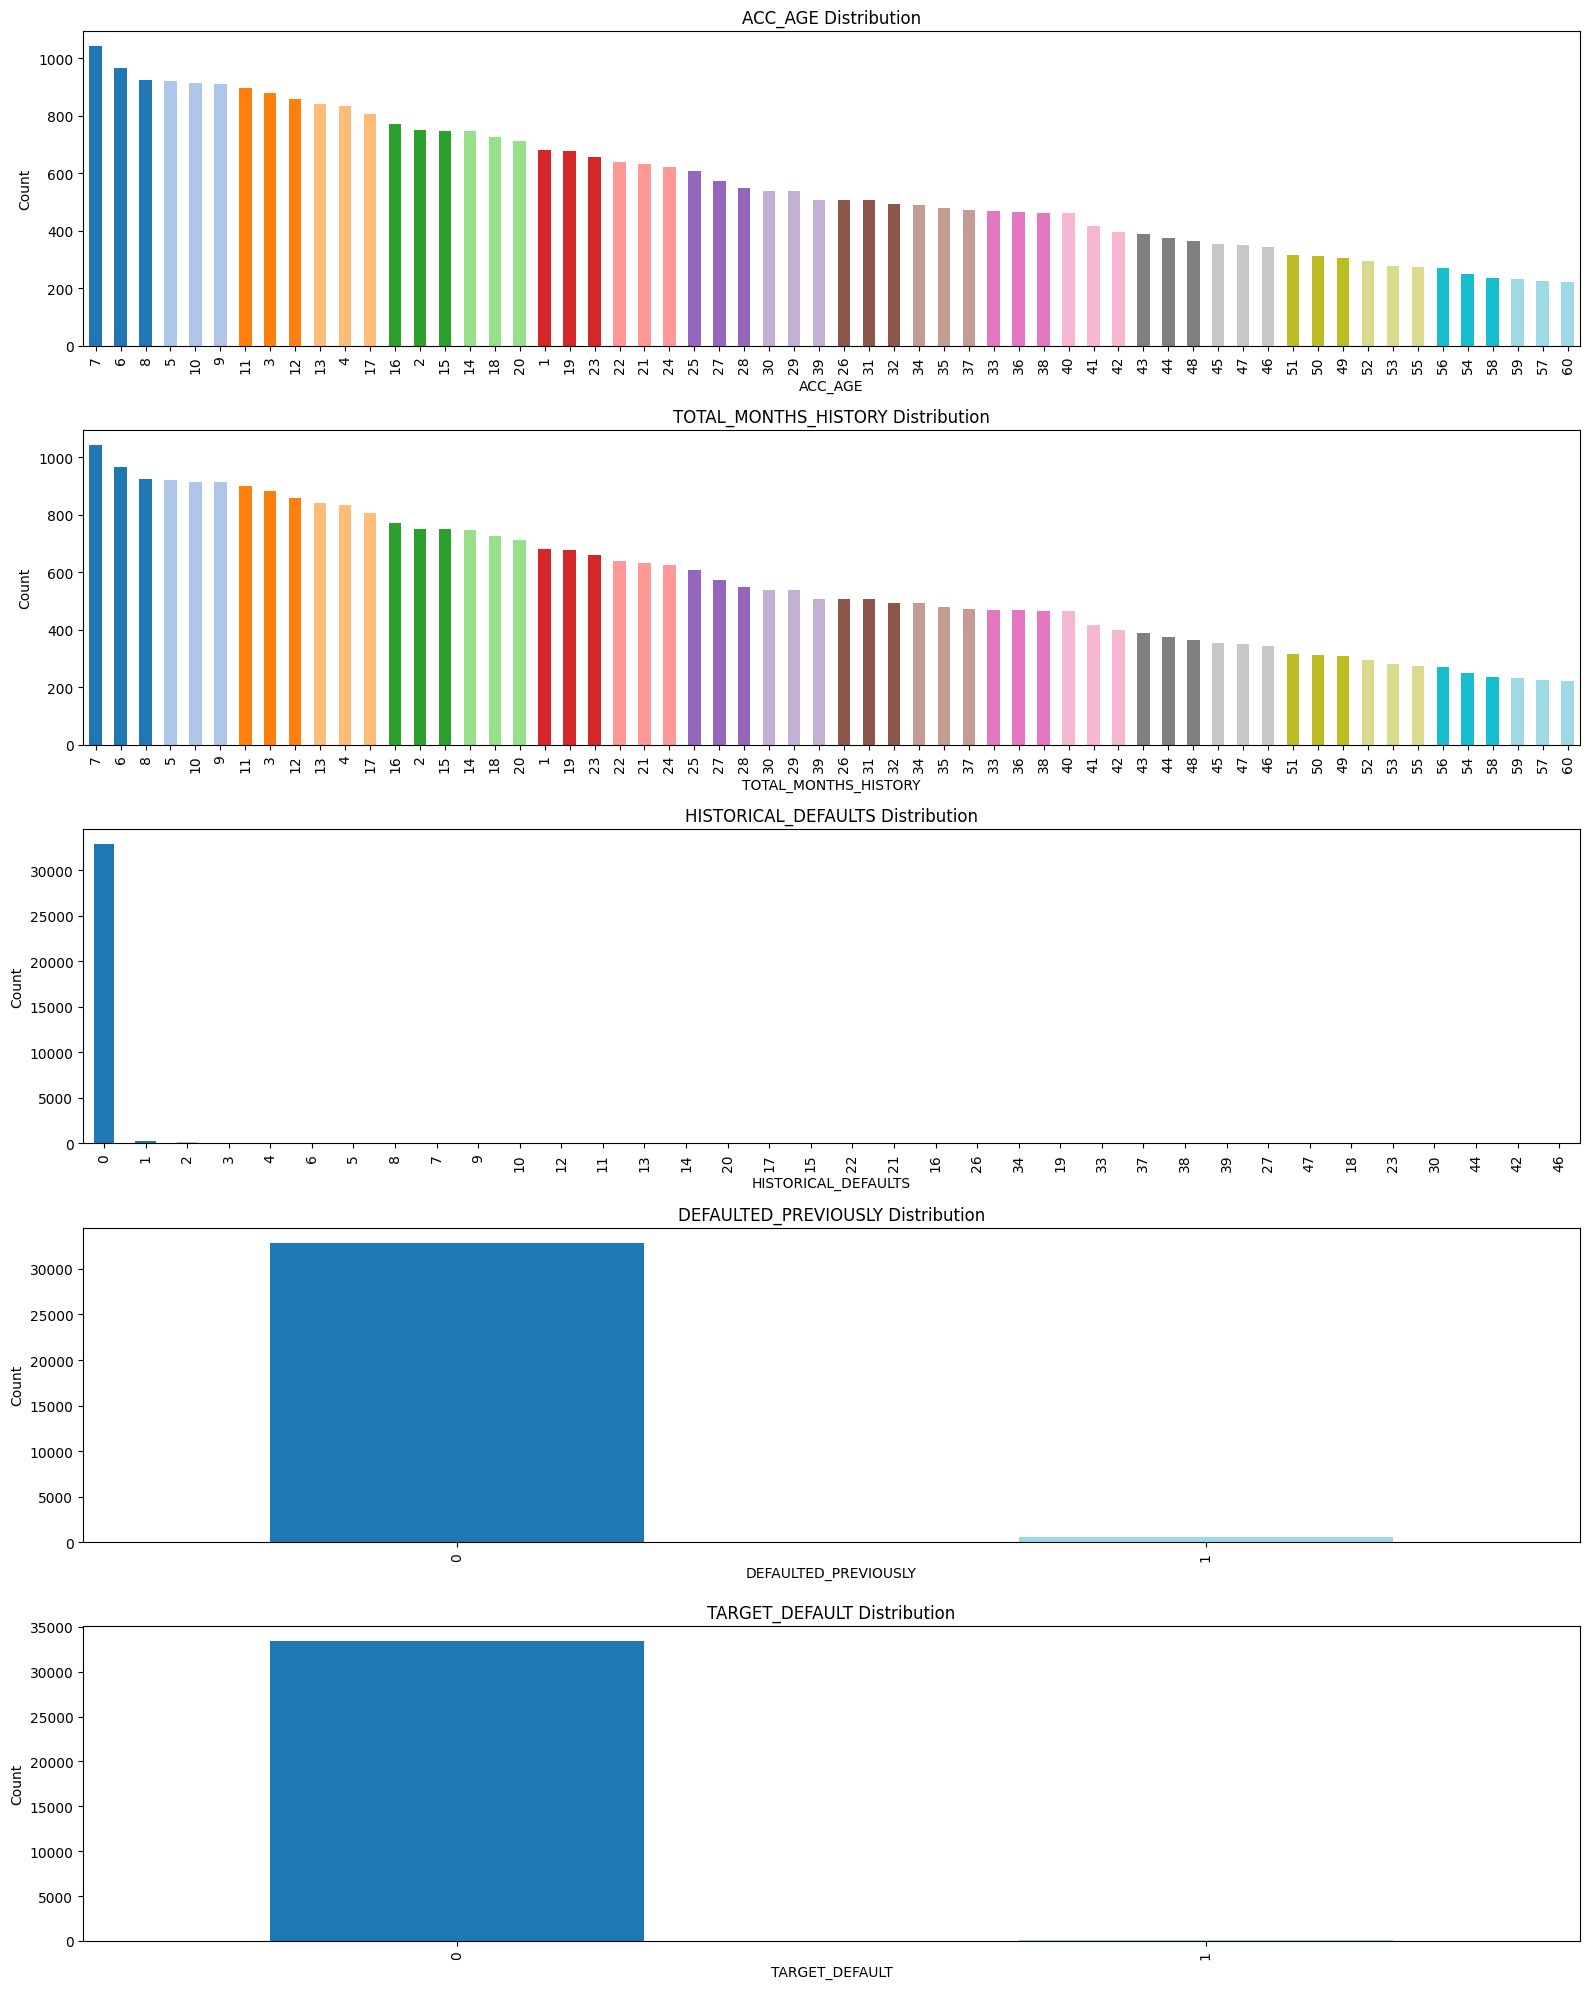

In [20]:
cols = ['ACC_AGE', 'TOTAL_MONTHS_HISTORY', 'HISTORICAL_DEFAULTS', 'DEFAULTED_PREVIOUSLY', 'TARGET_DEFAULT']
nrows = len(cols) # 4 columns per row
fig, axes = plt.subplots(nrows, 1, figsize=(16, 4*nrows))
axes = axes.flatten()  # Flatten to 1D array for easier iteration
cmap = plt.get_cmap('tab20')

# Plot each categorical column
for idx, col in enumerate(cols):
    colors = [cmap(i) for i in np.linspace(0, 1, len(df_cred_final[col].value_counts()))]
    df_cred_final[col].value_counts().plot(kind='bar', ax=axes[idx], color=colors)
    axes[idx].set_title(f'{col} Distribution')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')

# Hide unused subplots
for idx in range(len(cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()


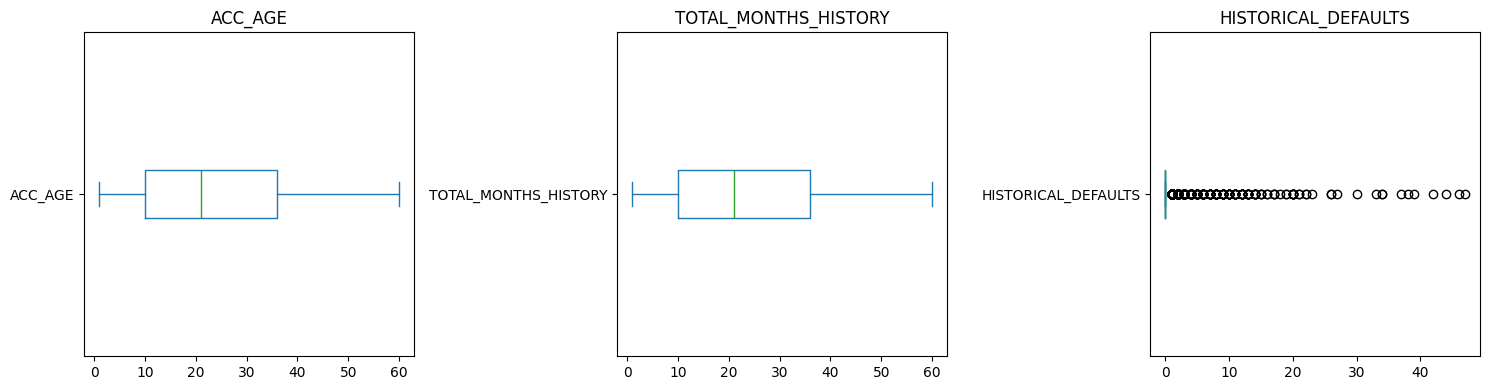

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Create box plots
df_cred_final['ACC_AGE'].plot(kind='box', vert=False, ax=axes[0], title='ACC_AGE')
df_cred_final['TOTAL_MONTHS_HISTORY'].plot(kind='box', vert=False, ax=axes[1], title='TOTAL_MONTHS_HISTORY')
df_cred_final['HISTORICAL_DEFAULTS'].plot(kind='box', vert=False, ax=axes[2], title='HISTORICAL_DEFAULTS')

plt.tight_layout()
plt.show()

#No Outliers found in credit record

In [ ]:
#Null and Duplicate values have been handled
#Before that we need to combine both application and credit records
df_merged = pd.merge(df_app_final, df_cred_final, left_on='CUST_ID', right_on='ID', how='left')

# This identifies the 400k+ people who have no record in credit_record.csv
df_merged['NO_CREDIT_HISTORY'] = df_merged['TARGET_DEFAULT'].isna().astype(int)

# We assume they are 'Good' (0) for training, but the flag above keeps the distinction
fill_values = {
    'ACC_AGE': 0, 
    'TOTAL_MONTHS_HISTORY': 0, 
    'HISTORICAL_DEFAULTS': 0, 
    'DEFAULTED_PREVIOUSLY': 0, 
    'TARGET_DEFAULT': 0
}
df_merged.fillna(fill_values, inplace=True)
df_merged.drop(columns=['ID'], inplace=True)

In [23]:
print("Null values in merged record:")
print(df_merged.isnull().sum()) #Successfully merged with no null values
print("Duplicate CUST_IDs in merged record:")
print(df_merged['CUST_ID'].duplicated().sum())#Successfully merged with no duplicate CUST_IDs

Null values in merged record:
CUST_ID                 0
GENDER                  0
OWN_CAR                 0
PROPERTY                0
NUM_CHILDREN            0
INCOME                  0
INCOME_TYPE             0
EDUCATION               0
FAMILY_STATUS           0
HOUSING_TYPE            0
AGE                     0
YEARS_EMPLOYED          0
MOBILE_STATUS           0
WORK_PHONE_STATUS       0
PHONE_STATUS            0
EMAIL_STATUS            0
OCCUPATION              0
CNT_FAM_MEMBERS         0
INCOME_GROWTH           0
INCOME_PCT_CHANGE       0
CAREER_CHANGES          0
TOTAL_EXPERIENCE        0
INCOME_STABILITY_CAT    0
ACC_AGE                 0
TOTAL_MONTHS_HISTORY    0
HISTORICAL_DEFAULTS     0
DEFAULTED_PREVIOUSLY    0
TARGET_DEFAULT          0
NO_CREDIT_HISTORY       0
dtype: int64
Duplicate CUST_IDs in merged record:
0


In [24]:
df_corr = df_merged.drop(columns=['CUST_ID'])

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_corr, drop_first=True)

# Calculate correlations with the target 'TARGET_DEFAULT'
correlations = df_encoded.corr()['TARGET_DEFAULT'].drop('TARGET_DEFAULT').sort_values(ascending=False)

# Output the top and bottom correlations
print("Top 10 Positive Correlations with TARGET_DEFAULT:")
print(correlations.head(10))
print("\nTop 10 Negative Correlations with TARGET_DEFAULT:")
print(correlations.tail(10))

Top 10 Positive Correlations with TARGET_DEFAULT:
HISTORICAL_DEFAULTS                   0.475589
DEFAULTED_PREVIOUSLY                  0.359120
TOTAL_MONTHS_HISTORY                  0.046739
ACC_AGE                               0.046739
OCCUPATION_IT staff                   0.008785
OCCUPATION_Security staff             0.004041
FAMILY_STATUS_Single / not married    0.003755
GENDER_M                              0.003665
OCCUPATION_Low-skill Laborers         0.002857
EMAIL_STATUS                          0.002768
Name: TARGET_DEFAULT, dtype: float64

Top 10 Negative Correlations with TARGET_DEFAULT:
INCOME_TYPE_Working         -0.001565
OCCUPATION_Drivers          -0.001705
FAMILY_STATUS_Married       -0.002013
NUM_CHILDREN                -0.002437
OCCUPATION_Realty agents    -0.002556
YEARS_EMPLOYED              -0.002688
TOTAL_EXPERIENCE            -0.002816
CNT_FAM_MEMBERS             -0.002909
INCOME_TYPE_State servant   -0.003691
MOBILE_STATUS                     NaN
Name: TARGET

In [ ]:
#One Hot Encode -> Gender, Own Car, Property, Income Stability Category
#Label Encode -> Income Type, Education, Family Status, Housing Type, Occupation
df_preprocess=df_merged.copy()
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
ohe_cols = ['GENDER', 'OWN_CAR', 'PROPERTY', 'INCOME_STABILITY_CAT']
le_cols = ['INCOME_TYPE', 'EDUCATION', 'FAMILY_STATUS', 'HOUSING_TYPE', 'OCCUPATION']
ohe = OneHotEncoder(drop='first', sparse_output=False)
le = LabelEncoder()
for col in ohe_cols:
    transformed = ohe.fit_transform(df_preprocess[[col]])
    ohe_df = pd.DataFrame(transformed, columns=[f"{col}_{cat}" for cat in ohe.categories_[0][1:]])
    df_preprocess = pd.concat([df_preprocess.reset_index(drop=True), ohe_df.reset_index(drop=True)], axis=1)
    df_preprocess.drop(columns=[col], inplace=True)

for col in le_cols:
    df_preprocess[col] = le.fit_transform(df_preprocess[col])
print(df_preprocess.head())

   CUST_ID  NUM_CHILDREN    INCOME  INCOME_TYPE  EDUCATION  FAMILY_STATUS  \
0  5008804             0  360000.0            4          1              0   
1  5008805             0  360000.0            4          1              0   
2  5008806             0  112500.0            4          4              1   
3  5008808             0  270000.0            0          4              3   
4  5008809             0  270000.0            0          4              3   

   HOUSING_TYPE  AGE  YEARS_EMPLOYED  MOBILE_STATUS  ...  HISTORICAL_DEFAULTS  \
0             4   32            12.0              1  ...                  0.0   
1             4   32            12.0              1  ...                  0.0   
2             1   58             3.0              1  ...                  0.0   
3             1   52             8.0              1  ...                  0.0   
4             1   52             8.0              1  ...                  0.0   

   DEFAULTED_PREVIOUSLY  TARGET_DEFAULT  NO_CREDIT

In [ ]:
#Normalize numerical features
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
num_cols = ['INCOME', 'AGE', 'YEARS_EMPLOYED','TOTAL_EXPERIENCE', 'ACC_AGE', 'TOTAL_MONTHS_HISTORY', 'HISTORICAL_DEFAULTS', 'TARGET_DEFAULT', 'INCOME_PCT_CHANGE', 'INCOME_PER_CAPITA']
df_preprocess[num_cols] = scaler.fit_transform(df_preprocess[num_cols])
print(df_preprocess.head())

   CUST_ID  NUM_CHILDREN    INCOME  INCOME_TYPE  EDUCATION  FAMILY_STATUS  \
0  5008804             0  1.000000            4          1              0   
1  5008805             0  1.000000            4          1              0   
2  5008806             0  0.126984            4          4              1   
3  5008808             0  0.682540            0          4              3   
4  5008809             0  0.682540            0          4              3   

   HOUSING_TYPE       AGE  YEARS_EMPLOYED  MOBILE_STATUS  ...  \
0             4  0.244898        0.250000              1  ...   
1             4  0.244898        0.250000              1  ...   
2             1  0.775510        0.062500              1  ...   
3             1  0.653061        0.166667              1  ...   
4             1  0.653061        0.166667              1  ...   

   HISTORICAL_DEFAULTS  DEFAULTED_PREVIOUSLY  TARGET_DEFAULT  \
0                  0.0                   0.0             0.0   
1                 

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

X = df_preprocess.drop(columns=['CUST_ID', 'TARGET_DEFAULT'])
Y = df_preprocess['TARGET_DEFAULT']

# 2. Train/Test Split
# We use stratify=Y because defaults are usually rare (imbalanced classes)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# 3. Initialize and Train the Random Forest
# n_jobs=-1 uses all your CPU cores for faster training
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=12, 
    class_weight='balanced_subsample',     # Limiting depth prevents overfitting
    random_state=42, 
    n_jobs=-1,
     # Highly recommended for imbalanced default data
)

rf_model.fit(X_train, Y_train)

# 4. Predictions
Y_pred = rf_model.predict(X_test)
Y_prob = rf_model.predict_proba(X_test)[:, 1]

# 5. Evaluation
print("--- Random Forest Performance ---")
print(f"Accuracy: {accuracy_score(Y_test, Y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(Y_test, Y_prob):.4f}")
print("\n--- Confusion Matrix ---")
print(confusion_matrix(Y_test, Y_pred))
print("\n--- Classification Report ---")
print(classification_report(Y_test, Y_pred))

--- Random Forest Performance ---
Accuracy: 0.9996
ROC AUC: 0.9980

--- Confusion Matrix ---
[[87656    28]
 [   10     8]]

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     87684
         1.0       0.22      0.44      0.30        18

    accuracy                           1.00     87702
   macro avg       0.61      0.72      0.65     87702
weighted avg       1.00      1.00      1.00     87702



In [31]:
df_trainset=df_preprocess[df_preprocess['NO_CREDIT_HISTORY'] == 0].copy()
X_train_final = df_trainset.drop(columns=['CUST_ID', 'TARGET_DEFAULT', 'NO_CREDIT_HISTORY'])
Y_train_final = df_trainset['TARGET_DEFAULT']
X_train, X_test, Y_train, Y_test = train_test_split(X_train_final, Y_train_final, test_size=0.2, random_state=42, stratify=Y_train_final)

# 3. Initialize and Train the Random Forest
# n_jobs=-1 uses all your CPU cores for faster training
rfm = RandomForestClassifier(
    n_estimators=100, 
    max_depth=12, 
    class_weight='balanced_subsample',     # Limiting depth prevents overfitting
    random_state=42, 
    n_jobs=-1,
     # Highly recommended for imbalanced default data
)

rfm.fit(X_train, Y_train)

# 4. Predictions
Y_pred = rfm.predict(X_test)
Y_prob = rfm.predict_proba(X_test)[:, 1]
# 5. Evaluation
print("--- Random Forest Performance ---")
print(f"Accuracy: {accuracy_score(Y_test, Y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(Y_test, Y_prob):.4f}")
print("\n--- Confusion Matrix ---")
print(confusion_matrix(Y_test, Y_pred))
print("\n--- Classification Report ---")
print(classification_report(Y_test, Y_pred))

--- Random Forest Performance ---
Accuracy: 0.9965
ROC AUC: 0.9517

--- Confusion Matrix ---
[[4849    5]
 [  12    6]]

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4854
         1.0       0.55      0.33      0.41        18

    accuracy                           1.00      4872
   macro avg       0.77      0.67      0.71      4872
weighted avg       1.00      1.00      1.00      4872



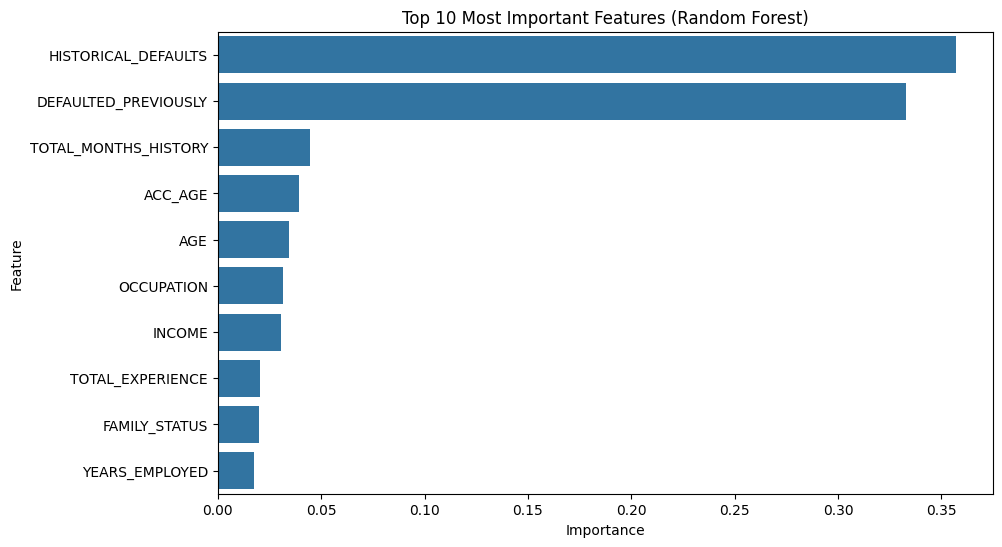

In [29]:
# Create a dataframe of feature importances
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rfm.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the top 10
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances.head(10))
plt.title('Top 10 Most Important Features (Random Forest)')
plt.show()

In [32]:
rfm.fit(X_train, Y_train)
# 4. Predictions
Y_pred_new = rfm.predict(X_test)
Y_prob_new = rfm.predict_proba(X_test)[:, 1]
# 5. Evaluation
print("--- Random Forest Performance ---")
print(f"Accuracy: {accuracy_score(Y_test, Y_pred_new):.4f}")
print(f"ROC AUC: {roc_auc_score(Y_test, Y_prob_new):.4f}")
print("\n--- Confusion Matrix ---")
print(confusion_matrix(Y_test, Y_pred_new))
print("\n--- Classification Report ---")
print(classification_report(Y_test, Y_pred_new))

--- Random Forest Performance ---
Accuracy: 0.9965
ROC AUC: 0.9517

--- Confusion Matrix ---
[[4849    5]
 [  12    6]]

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4854
         1.0       0.55      0.33      0.41        18

    accuracy                           1.00      4872
   macro avg       0.77      0.67      0.71      4872
weighted avg       1.00      1.00      1.00      4872

